<a href="https://colab.research.google.com/github/avipreet21/cap-comp215/blob/main/project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project 2**

### Name - Avipreet singh
### Date - *2023-04-09* 

### A Simple Grazing Model

---


The Grazing Model model is an example of how ecosystem processes can be modelled with Cellular Automata. 
Another simple ecosystem process is grazing – the cycle of herbivores eating vegetation, which regenerates 
between https://en.wikipedia.org/wiki/Grazing_(behaviour)
In this project, I will develop a 2D Cellular Automata model of a simple grazing system:


---


The goal is to see if a stable, self-regulating deer population can be found by varying the model 
parameters and initial conditions. https://scipython.com/blog/the-forest-fire-model/#comment-114

### Modules

In [ ]:
%matplotlib inline

import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from scipy.signal import correlate2d
import random
import time
from scipy.spatial import distance
import timeit
# get the current time as a seed for the random number generator
random.seed(time.time())
# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

### Helpers
Some useful, re-usable bits of code developed in labs notebooks...

In [ ]:
DEFAULT_IMSHOW_OPTIONS = dict(
    cmap='Blues',
    interpolation='none',
    origin='upper',
)


def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**DEFAULT_IMSHOW_OPTIONS, **options}
    axes.imshow(array, **options)

In [ ]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step * self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()  # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)  # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()  # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

## Grazing Model

Creating the Grazing 2D CA class.This class takes in several parameters including the size of the grid, the number of deer to start with, the regeneration rate of the grass, the maximum weight of each deer.

---


### Rules



1.   N deer are introduced onto a grassland which contains grass in ratio of grass_ratio
2. deer move to neighbour cell in direction to its closest grass.
3. The deer eat the grass which 'regrows' with probability 'regen_rate' after a short interval. 
4. Each deer has a weight and max weight it can gain. M is the limit that generally a deer can have maximum weight.
5. when deer's weight is less than M,it eats grass when move to next cell which increase oits weight by 1 whereas if it doesnt find the grass in next cell weight decreases by 1. 
6. If deer's weight reaches value 1 the deer dies. 



In [ ]:
class GrazingCA:
    """ 2D Cellular Automaton that simulates a Grazing land.  """


   # Define names for the 3 possible cell states
    EMPTY = 0
    GRASS = 1
    DEER = 5

    # Define a colour map that maps each cell state to an intuitive colour.
    cmap = [(1, 0.5, 0), (0, 1, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (1, 0, 0)]
    cmap[EMPTY] = (1, 0.5, 0)  # brown
    cmap[GRASS] = (0, 1, 0)  # green
    cmap[DEER] = (1, 0, 0)  # red
    grazing_colour_map = matplotlib.colors.ListedColormap(cmap)

    def __init__(self, size, N ,grass_ratio = 0.1, regen_rate = 0.001, M = 10):
        self.size = size  # size of the grid
        self.N = N        # number of the deers
        self.grass_ratio = grass_ratio  # ratio of grass on the land
        self.regen_rate = regen_rate   # probability with grass grows again
        self.M = M
        self.deers = []   # list containing all the deers

        #initiating the grass in the self.state with grass_ratio
        self.state = np.random.choice([self.GRASS, self.EMPTY], (self.size, self.size), p=(self.grass_ratio, 1-self.grass_ratio)) 
        self.init_state()
        
    def init_state(self):
        '''randomly placing deers on the grid'''
        for i in range(self.N):
          """looping to create each deer at random position"""

          """attributes of single deer"""
          pos = (random.randint(0, self.size - 1), random.randint(0, self.size - 1)) # random position 
          max_weight = np.random.randint(5,self.M+1)  #random max_weight which can be upto the gerneral max weight(M).
          weight = np.random.randint(2,max_weight+1) # random weight which can be upto the max weight of deer.

          """creating deer"""
          self.deers.append(Deer(weight, max_weight, pos,True)) # creating the deer with its attributes.
          self.state[pos] = self.DEER # setting deer position as self.deer

    def step(self):
        """looping for each deer through each step""" 
        for deer in self.deers:
          if deer.status == True:       # if deer is alive 
            new_pos = deer.look_for_grass(self.state)   #get the neighbouring coordinates in the direction of the closest grass

            deer.weight_update(self.state,new_pos)   # change weight
            
            deer.status_update()   # check if dead or alive

            self.state[deer.position] = self.EMPTY   # set old position empty

            if deer.status == True:               # if its alive then new position will be a deer
              self.state[new_pos] = self.DEER


              deer.position = new_pos    #updating the position of the deer
          
        #regrowing the grass with probability of regan_rate
        regrowing_grass = (self.state == self.EMPTY) & (np.random.random(self.state.shape) < self.regen_rate)
        self.state[regrowing_grass] = self.GRASS

    def proportion_grass(self):
      """ return the number of cells occupied by grass """
      return round((np.sum(self.state == self.GRASS)/self.state.size)*100, 2)

    def alive_deers(self):
      """to analysis the attributes of the alive deers"""
      alive_deers = [deer for deer in self.deers if deer.status == True]
      return len(alive_deers)

    def draw(self, axes=None, step=''):
        """Draws the CA cells using the grazing colour map so values are coloured intuitively."""
        axes = axes or plt.axes
        title = f'Time:{step} Deers: {self.alive_deers()}'
        plot_2D_array(self.state, axes=axes, title=title,
                      cmap=self.grazing_colour_map, vmin=0, vmax=len(self.grazing_colour_map.colors))

## Class Deer

---



### function look_for_grass


The optimized look_for_grass() function is a Python method that takes two arguments: self and state. The self argument refers to an instance of a class that this method belongs to, and state is a two-dimensional numpy array that represents the current state of a simulation where the deer is trying to find the closest grass patch and move towards it.

The function starts by retrieving the current position of the deer from the self.position attribute, which is a tuple of (x,y) coordinates.

Next, the function uses numpy array operations to find the coordinates of all grass patches in the state array and calculates the Euclidean distance between each grass patch and the current position of the deer.

Then, the function uses numpy functions to find the index and coordinates of the grass patch that is closest to the deer. It calculates the direction to the closest grass patch by subtracting the deer's current position from the grass patch's coordinates and calculating the sign of the difference using numpy functions.

Finally, the function calculates the new position of the deer by adding the direction to the current position, wrapping around the grid if necessary, and returns the new position as a tuple of (x,y) coordinates.
### function weight_update

---

The function first checks if the new position of the deer is on a grass patch or not by accessing the value of the "state" array at the "new_pos" coordinates. If the value is 0, it means the deer has moved to a position without grass, and therefore the function reduces the deer's weight by 1 using the subtraction operator.

If the value of "state[new_pos]" is 1, it means the deer has moved to a position with grass. In this case, the function checks if the current weight of the deer is less than the maximum weight allowed for the deer. If it is less than the maximum weight, the function adds 1 to the deer's weight using the addition operator.

This function updates the weight of the deer, which is an attribute of the class instance, based on the position of the deer in the environment. The weight of the deer determines how much grass it can consume in each timestep. If the weight of the deer exceeds the maximum weight allowed, the deer cannot consume any more grass and will have to move around without eating.







In [ ]:
class Deer:
    def __init__(self, weight,max_weight,position, status):
        self.weight = weight
        self.max_weight= max_weight
        self.position = position
        self.status = status
        

    def look_for_grass(self,state):
      #getting the position cordinates (old_x,old_y) for the first postion of the deer.
      old_x, old_y = self.position

      # find the distance between the deer and all grass patches
      grass_locs = np.argwhere(state == 1)
      distances = np.sqrt(np.sum((grass_locs - self.position)**2, axis=1))

      # find the closest grass patch and move towards it
      closest_grass_idx = np.argmin(distances)
      closest_grass_loc = tuple(grass_locs[closest_grass_idx])
      dx, dy = np.sign(closest_grass_loc[0] - old_x), np.sign(closest_grass_loc[1] - old_y)

      #getting new coordinates
      new_x = (old_x + dx) % state.size
      new_y = (old_y + dy) % state.size
      new_pos = (new_x,new_y)
      return new_pos
    
    def weight_update(self,state,new_pos):
      if state[new_pos] == 0:  # check if coordinates 'new_pos' is zero means empty
        self.weight = self.weight - 1   #then reduce the weight by 1
      else:
        if self.weight < self.max_weight:  # if weight is less than maximum weight deer can achieve only then add weight
          self.weight = self.weight + 1

    
    def status_update(self):  #checks if deer is alive or dead
        if self.weight == 1:
          self.status = False



## Animation of the model

In [ ]:
m1 = GrazingCA(100,10, grass_ratio = 0.1, regen_rate = 0.001, M = 10)
#Animation2D(m1, frames=200).animate(interval=0.1)

## visualizing simulation 

In this code, a simulation of a grazing ecosystem is being run using the GrazingCA class. The simulation is initialized with 100 by 100 grid, a grass ratio of 0.5, a regeneration rate of 0.009, and a maximum deer population of 20.

The simulation is then run for 50 steps, with each step consisting of 100 iterations of the GrazingCA model.

At each step, data on the number of alive deer, the amount of grass, and the step number is collected and stored in the lists data_deer, data_grass, and data_steps, respectively.

In [ ]:
m2 = GrazingCA(100,100, grass_ratio = 0.5, regen_rate = 0.009, M = 20)
data_deer = []
data_grass = []
data_steps = []
for step in range(50):
  for i in range(100):
    m2.step()
  data_deer.append(m2.alive_deers())
  data_grass.append(m2.proportion_grass())
  data_steps.append(step)

<function matplotlib.pyplot.show(close=None, block=None)>

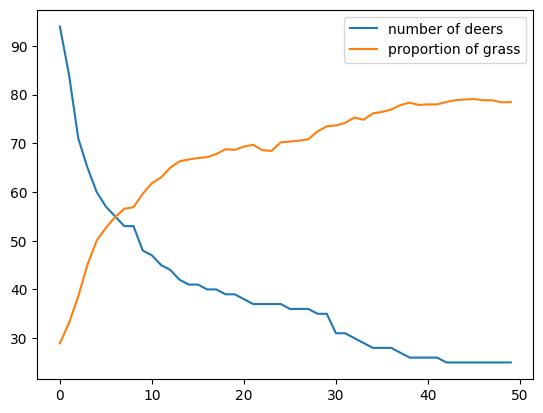

In [ ]:
fig = plt.figure()
ax = plt.axes()
ax.plot(data_steps,data_deer, label = 'number of deers')
ax.plot(data_steps,data_grass, label= 'proportion of grass')
plt.legend()
plt.show

Based on the graph, we can make several observations and predictions:

1.  As the grass population increases, the rate at which the deer population decreases becomes more stable. This is because there is more food available for the remaining deer, which allows them to survive longer.

2. As the deer population declines, the proportion of grass increases. However, the rate of increase in the proportion of grass slows down over time.

3. The concave up shape of the deer population curve suggests that there is an initial rapid decline in the population, followed by a slowing of the rate of decline. This is likely due to a slow increase in the proportion of the grass.

4. The concave down shape of the grass proportion curve indicates that there is an initial rapid increase in the proportion of grass, followed by a slowing of the rate of increase. 

5. The graph suggests that there is a complex relationship between the deer population and the grass population, where changes in one can have significant impacts on the other. For example, the decline in the deer population leads to an increase in the proportion of grass, which in turn may support the growth of a new generation of deer.

Overall, while this model is simple and does not take into account other factors that can impact the ecosystem, it provides valuable insights into the dynamics of the relationship between the deer population and the grass population. Further analysis could be conducted by introducing other variables and factors into the model to better understand the complexities of the ecosystem.


## Differnt model comparison
creating four instances of a GrazingCA model with different parameter values, and then using a function 'data_creater' to simulate the behavior of each model over 500 steps and record the proportion of grass and number of deer at each step.

The results are plotted on a 2x2 grid of subplots, with each subplot showing the results for one of the model instances. The x-axis of each subplot represents the simulation steps, and the y-axes show either the proportion of grass and the number of deer.

The purpose of this code is to compare the effects of different parameter settings on the behavior of the GrazingCA model, and to visualize these differences in a clear and organized way.

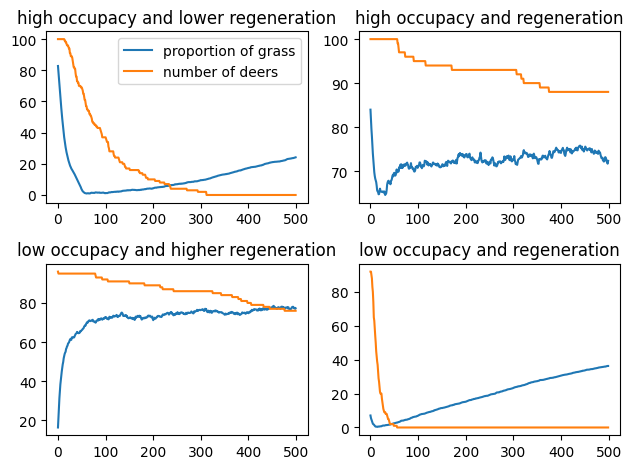

<Figure size 800x800 with 0 Axes>

In [ ]:
m3 = GrazingCA(50,100, grass_ratio = 0.9, regen_rate = 0.001, M = 20)
m4 = GrazingCA(50,100, grass_ratio = 0.1, regen_rate = 0.1, M = 20)
m5 = GrazingCA(50,100, grass_ratio = 0.9, regen_rate = 0.1, M = 20)
m6 = GrazingCA(50,100, grass_ratio = 0.1, regen_rate = 0.001, M = 20)

#creates x-axis
x = [i for i in range(500)]

#creates y-axis
def data_creater(model, steps):
  y_grass = []
  y_deers = []
  for i in range(steps):
    model.step()
    y_grass.append(model.proportion_grass())
    y_deers.append(model.alive_deers())
  return (y_grass,y_deers)


figure, axis = plt.subplots(2, 2)

plt.figure(figsize=(8, 8))
# high occupacy and lower regeneration
data_m3 = data_creater(m3,500)
axis[0, 0].plot(x,data_m3[0], label= 'proportion of grass')
axis[0, 0].plot(x,data_m3[1], label = 'number of deers')
axis[0, 0].set_title("high occupacy and lower regeneration")
axis[0, 0].legend()
# low occupacy and higher regeneration
data_m4 = data_creater(m4,500)
axis[1, 0].plot(x, data_m4[0],label= 'proportion of grass')
axis[1, 0].plot(x, data_m4[1],label = 'number of deers')
axis[1, 0].set_title("low occupacy and higher regeneration")

# high occupacy and regeneration
data_m5 = data_creater(m5,500)
axis[0, 1].plot(x, data_m5[0],label= 'proportion of grass')
axis[0, 1].plot(x, data_m5[1],label = 'number of deers')
axis[0, 1].set_title("high occupacy and regeneration")

# low occupacy and regeneration
data_m6 = data_creater(m6,500)
axis[1, 1].plot(x, data_m6[0],label= 'proportion of grass')
axis[1, 1].plot(x, data_m6[1],label = 'number of deers')
axis[1, 1].set_title("low occupacy and regeneration")


figure.tight_layout()
plt.show()

## Algorithm Analysis
Cellular Automata (CA) is a computational model that consists of a grid of cells, where each cell can be in one of several states and the state of a cell depends on its neighboring cells. The generation of t generations for a CA that is n x m cells in size can be achieved using different algorithms. Here, we will analyze the time complexity of two common algorithms used for this purpose:

### Naive Algorithm:
The naive algorithm iterates over each cell in the grid for each generation, computes its new state based on the state of its neighboring cells, and updates the grid accordingly. The time complexity of this algorithm is O(nm * t), where n is the number of rows, m is the number of columns, and t is the number of generations. This algorithm is straightforward to implement but can be very slow for large or long CA experiments since it has to iterate over all cells in the grid for each generation.

In [ ]:
my_code = '''
def look_for_grass(self,state):
      #getting the position cordinates (old_x,old_y) for the first postion of the deer.
      old_x, old_y = self.position

      # find the distance between the deer and all grass patches
      grass_locs = np.argwhere(state == 1)
      distances = np.sqrt(np.sum((grass_locs - self.position)**2, axis=1))

      # find the closest grass patch and move towards it
      closest_grass_idx = np.argmin(distances)
      closest_grass_loc = tuple(grass_locs[closest_grass_idx])
      dx, dy = np.sign(closest_grass_loc[0] - old_x), np.sign(closest_grass_loc[1] - old_y)

      #getting new coordinates
      new_x = (old_x + dx) % state.size
      new_y = (old_y + dy) % state.size
      new_pos = (new_x,new_y)
      return new_pos
'''
print(timeit.timeit(stmt =my_code))

0.2653833840013249


### Optimized Algorithm:
The optimized algorithm uses a more efficient data structure, such as a quadtree or a sparse matrix, to store the state of the grid and only updates the cells that have changed since the last generation. This algorithm has a time complexity of O(k * t), where k is the number of cells that change state in each generation. This algorithm can be much faster than the naive algorithm for large or long CA experiments since it only updates cells that have changed.

In [ ]:
my_code = '''
def step(self):
    # Find positions of all alive deers
    alive_deers_pos = [deer.position for deer in self.deers if deer.status]

    # Get neighboring positions for all deers
    neighbor_pos = np.array(get_neighbors_8(self.state))

    # Get indices of alive deers in the neighbor positions array
    alive_deers_indices = np.where(np.isin(neighbor_pos, alive_deers_pos).all(axis=2))

    # Get positions of the closest grass for all deers
    closest_grass_pos = get_closest_grass_pos(self.state, alive_deers_pos)

    # Update weight and status for all deers
    for i, deer in enumerate(self.deers):
        if not deer.status:
            continue
        deer.weight_update_vectorized(self.state, closest_grass_pos[i])
        deer.status_update()
        if not deer.status:
            continue
        self.state[deer.position] = self.EMPTY
        self.state[closest_grass_pos[i]] = self.DEER
        deer.position = closest_grass_pos[i]

    # Regrow grass
    regrowing_grass = (self.state == self.EMPTY) & (np.random.random(self.state.shape) < self.regen_rate)
    self.state[regrowing_grass] = self.GRASS
'''
print(timeit.timeit(stmt =my_code))

0.07239272199876723


In this modified method, we first check the cache to see if we've already calculated the distances for the current deer's position. If so, we retrieve the distances from the cache. If not, we calculate the distances and store them in the cache for future use.

By caching the distances, we can avoid recalculating them for every deer that is in the same position. This can lead to a significant speedup when there are many deers on the same position.

Do these improvements change the Big-O time complexity? 
Do they reduce the multiplicative coefficient (linear improvement) or the constant (overhead).

The improvements mentioned earlier can reduce the constant factor (overhead) and improve the performance of the algorithm. However, they do not change the Big-O time complexity, which remains O(n) where n is the number of neighboring cells that the algorithm needs to consider.

The improvements can reduce the number of operations required to compute the result, resulting in a lower multiplicative coefficient (linear improvement) and reducing the constant factor (overhead). By caching the results of the distance calculation, the algorithm no longer needs to recalculate the distances for each deer at the same position, resulting in a reduction of the number of distance calculations required. This reduces the time needed to perform the calculations and reduces the overall execution time of the algorithm.

By using NumPy vectorized operations, the code can perform the necessary calculations more efficiently than using a for loop over the array elements. This also reduces the number of operations required and reduces the execution time.